In [16]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.inceptionv4 import InceptionV4
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [3]:
IMAGE_SIZE = 299
BATCH_SIZE = 32

In [4]:
artifact_path = Path("../../artifacts/inceptionv4")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [5]:
DEVICE = torch.device("cuda:0")

# data

In [6]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [9]:
NUM_CLASS = 43

In [10]:
len(train_dataset)

26640

9


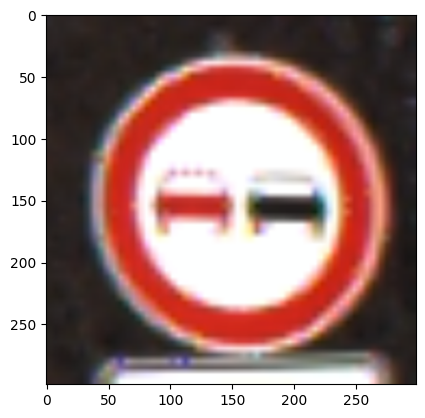

In [11]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [12]:
model = InceptionV4(output_size=NUM_CLASS).to(DEVICE)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
InceptionV4                                                       --
├─Sequential: 1-1                                                 --
│    └─Conv2dNormActivation: 2-1                                  --
│    │    └─Conv2d: 3-1                                           864
│    │    └─BatchNorm2d: 3-2                                      64
│    │    └─ReLU: 3-3                                             --
│    └─Conv2dNormActivation: 2-2                                  --
│    │    └─Conv2d: 3-4                                           9,216
│    │    └─BatchNorm2d: 3-5                                      64
│    │    └─ReLU: 3-6                                             --
│    └─Conv2dNormActivation: 2-3                                  --
│    │    └─Conv2d: 3-7                                           18,432
│    │    └─BatchNorm2d: 3-8                                      128
│    │    └─ReLU: 3-

# training

In [14]:
EPOCHS = 10
ACC_ITERS = 1

In [17]:
trainer = ClassificationTrainer(EPOCHS, DEVICE, ACC_ITERS)
trainer.recorder.increment_data_size(len(train_dataset))

In [19]:
criterion = trainer.get_criterion(NUM_CLASS, label_smoothing=1e-3)
optim = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [20]:
training_loss = trainer.run(train_loader, model, optim, criterion)

Enable AMP: False
Training...


100%|██████████| 832/832 [17:24<00:00,  1.26s/it]


------------------------------------
Epoch 1
------------------------------------
total: 1.0099e-01 (0.00%)


100%|██████████| 832/832 [07:00<00:00,  1.98it/s]


------------------------------------
Epoch 2
------------------------------------
total: 5.9977e-02 (-41.00%)


100%|██████████| 832/832 [05:10<00:00,  2.68it/s]


------------------------------------
Epoch 3
------------------------------------
total: 3.3385e-02 (-44.00%)


100%|██████████| 832/832 [04:38<00:00,  2.99it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.2001e-02 (-64.00%)


100%|██████████| 832/832 [04:44<00:00,  2.92it/s]


------------------------------------
Epoch 5
------------------------------------
total: 6.8993e-03 (-43.00%)


100%|██████████| 832/832 [04:47<00:00,  2.89it/s]


------------------------------------
Epoch 6
------------------------------------
total: 4.6887e-03 (-32.00%)


100%|██████████| 832/832 [04:42<00:00,  2.95it/s]


------------------------------------
Epoch 7
------------------------------------
total: 3.6599e-03 (-22.00%)


100%|██████████| 832/832 [04:41<00:00,  2.95it/s]


------------------------------------
Epoch 8
------------------------------------
total: 3.1341e-03 (-14.00%)


100%|██████████| 832/832 [04:39<00:00,  2.98it/s]


------------------------------------
Epoch 9
------------------------------------
total: 2.5179e-03 (-20.00%)


100%|██████████| 832/832 [04:43<00:00,  2.94it/s]

------------------------------------
Epoch 10
------------------------------------
total: 2.1916e-03 (-13.00%)


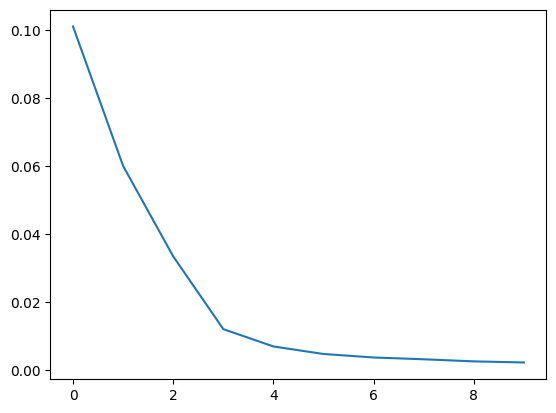

In [21]:
plt.plot(training_loss)

# inference

In [22]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [23]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [24]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [25]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [26]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 395/395 [03:29<00:00,  1.89it/s]


In [27]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(NUM_CLASS), per_class_acc)

0         : 1.0
1         : 0.9902777777777778
2         : 0.9893333333333333
3         : 0.9711111111111111
4         : 0.9666666666666667
5         : 0.953968253968254
6         : 0.8666666666666667
7         : 0.9577777777777777
8         : 0.9355555555555556
9         : 0.9979166666666667
10        : 0.9893939393939394
11        : 0.9714285714285714
12        : 0.9666666666666667
13        : 0.9916666666666667
14        : 0.9851851851851852
15        : 0.8047619047619048
16        : 1.0
17        : 0.9361111111111111
18        : 0.8743589743589744
19        : 0.9833333333333333
20        : 0.7
21        : 0.6666666666666666
22        : 0.7416666666666667
23        : 0.98
24        : 0.9777777777777777
25        : 0.8833333333333333
26        : 0.95
27        : 1.0
28        : 0.9733333333333334
29        : 1.0
30        : 0.9133333333333333
31        : 1.0
32        : 0.8333333333333334
33        : 0.9
34        : 0.8666666666666667
35        : 0.9179487179487179
36        : 0.975


In [28]:
per_class_acc.mean()

np.float64(0.9093221748386058)

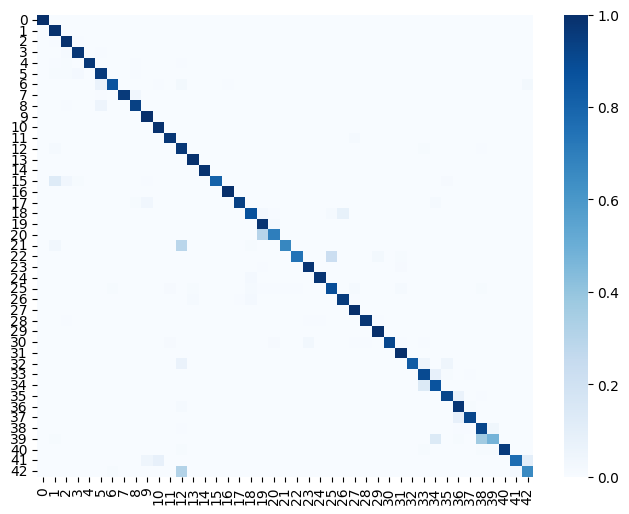

In [29]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(NUM_CLASS),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [30]:
model_path = artifact_path / f'inceptionv4.pth'

In [31]:
torch.save(model.state_dict(), model_path)

In [32]:
get_file_size(model_path)

'157.76MiB'

In [33]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>